In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [4]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        action_probs = np.zeros(len(Q[observation]))
        best_action = np.argmax(Q[observation])
        action_probs[best_action] = 1
        
        return action_probs
        
    return policy_fn

In [18]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    
    for i in range(num_episodes):
        observation = env.reset()
        episode = []
        done = False
        while not done:
            action_probs = behavior_policy(observation)
            action = np.random.choice(len(action_probs), p=action_probs)
            next_observation, reward, done, _ = env.step(action)
            episode.append((observation, action, reward))
            observation = next_observation
                        
        visited = set()
        for j in range(len(episode)):
            sa = episode[j][:2]
            if sa not in visited:
                visited.add(sa)
                reward = sum(discount_factor**(k - j) * episode[k][2] for k in range(j, len(episode)))
                C = 1.
                for k in range(j, len(episode)):
                    C *= target_policy(episode[k][0])[episode[k][1]] / behavior_policy(episode[k][0])[episode[k][1]]
                
                returns_sum[sa] = C * reward + returns_sum[sa] if sa in returns_sum else C * reward
                returns_count[sa] = returns_count[sa] + C if sa in returns_count else C
        
        for sa in returns_sum.keys():
            Q[sa[0]][sa[1]] = returns_sum[sa] / returns_count[sa]
        
    return Q, target_policy

In [19]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

/home/ilya/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in double_scalars


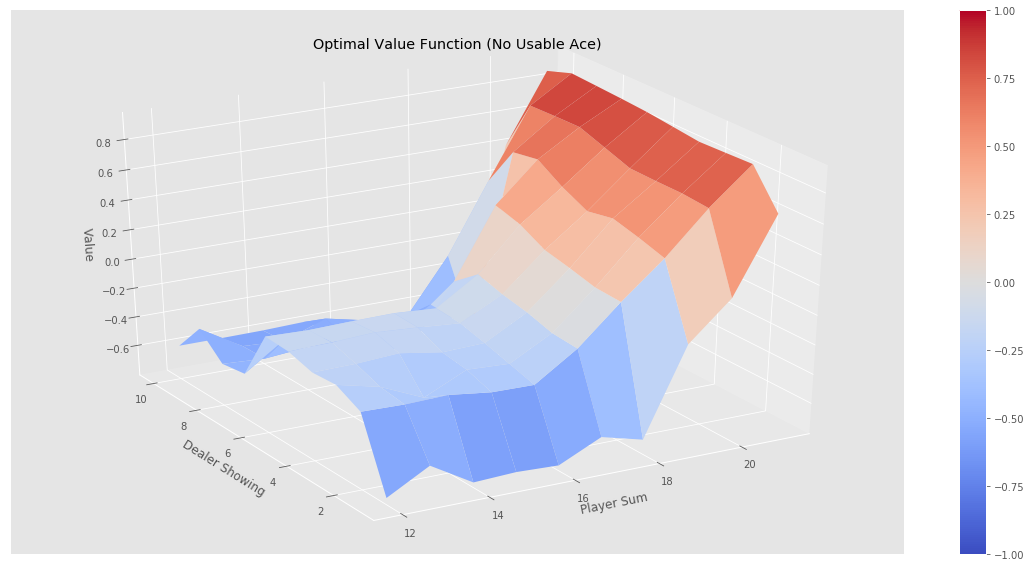

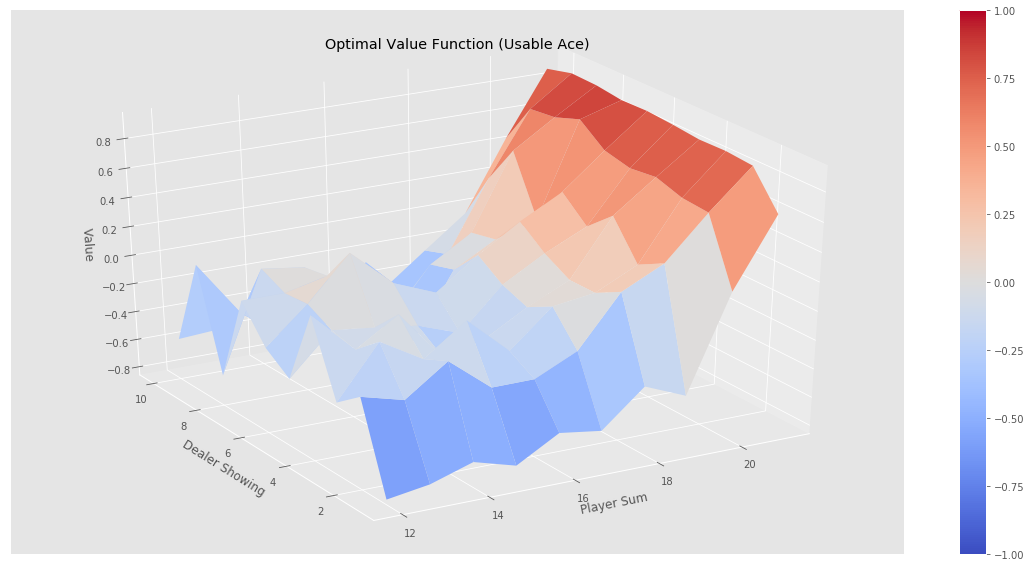

In [20]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")